## Import libraries

In [1]:
!pip install pymanopt # install pymanopt manually

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.5 MB/s eta 0:00:00


In [66]:
# math
import math
import numpy as np
from numpy.random import multivariate_normal as mvn
import numpy.linalg as la
from scipy.stats import ortho_group, uniform, bernoulli
from scipy.linalg import sqrtm, norm, expm, logm
from scipy.optimize import minimize

# plotting/visualization
import matplotlib.pyplot as plt

# pymanopt: for Rayleigh quotient maximization
from pymanopt.manifolds import Sphere
from pymanopt.manifolds import SymmetricPositiveDefinite

# torch: for mean-field training
import torch
import torch.nn as nn

## Utils

### Matrix utils

In [3]:
def gen_matrix_with_eigs(eigs):
    """
    Generates a symmetric matrix with eigenvalues `eigs`.
    """
    dim = len(eigs)
    x = ortho_group.rvs(dim)
    return x.T @ np.diag(eigs) @ x

def gen_matrix_with_eigbounds(low, high, dim: int):
    """
    Generates a symmetric matrix with eigenvalues within [low, high].
    """
    eigs = low + (high - low) * uniform.rvs(size=dim)
    return gen_matrix_with_eigs(eigs)

def enforce_spd(S, eps=1e-15):
    """Project a symmetric matrix to SPD by eigenvalue flooring."""
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)                 # symmetric eigendecomp is most stable
    # scale-aware floor: keeps conditioning sane without over-regularizing
    floor = max(eps, 1e-12 * max(1.0, np.max(np.abs(w))))
    w_clipped = np.clip(w, floor, None)
    return (V * w_clipped) @ V.T

def safe_inv_spd(S, eps=1e-15):
    """Inverse via eigen-decomposition with eigenvalue flooring (SPD only)."""
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)
    floor = max(eps, 1e-12 * max(1.0, np.max(np.abs(w))))
    w_clipped = np.clip(w, floor, None)
    inv_w = 1.0 / w_clipped
    return (V * inv_w) @ V.T

def mvn_safe(mu, Sigma, size=1, rng=None):
    """Multivariate normal with SPD projection and Cholesky."""
    if rng is None:
        rng = np.random.default_rng()
    Sigma = enforce_spd(Sigma)
    L = np.linalg.cholesky(Sigma)
    mu = np.asarray(mu)
    d = mu.shape[0]
    z = rng.normal(size=(size, d))
    return mu + z @ L.T

### Parallel Transports

In [4]:
def grad_transport_map(Sigma_0, Sigma_1):
  """
  Return Gradient of Transport map between N(0, Sigma_0), N(0,Sigma_1) = sqrt(0)^-1 @ sqrt(sqrt(0) @ 1 @ sqrt(0)) @ sqrt(0)^-1 = 0^-1 @ sqrt(0 @ 1)
  """
  end = sqrtm(Sigma_0 @ Sigma_1)
  return np.linalg.inv(Sigma_0) @ end

def gaussian_composition(mu_1, a, S, b, R):
  """
  Return the composition of the transport map at (a,S) \in N(mu_1, Sigma_1) (a,S) \circ (b,R)
  """
  vec = a + S.dot(b) - S.dot(mu_1)
  mat = S @ R
  return vec, mat

def gaussian_transport(Sigma_0, Sigma_1, a, S):
  """
  Transports S in T_sigma_1 to T_sigma_0
  """
  vec = a
  mat = S @ grad_transport_map(Sigma_0, Sigma_1)
  return vec, mat

def gaussian_interpolation(mean_0, Sigma_0, mean_1, Sigma_1, t):
  """
  Return interpolating Gaussian distribution
  """
  mean_t = (1 - t) * mean_0 + t * mean_1
  Sigma_t = ((1-t)**2) * Sigma_0 + t * (1-t) * (sqrtm(Sigma_0 @ Sigma_1) + sqrtm(Sigma_1 @ Sigma_0)) + (t ** 2) * Sigma_1
  return mean_t, Sigma_t

def bw_inner_product(a, S, b, R, Sigma):
  vec = np.dot(a,b)
  mat = np.linalg.trace(S @ Sigma @ R)
  return vec + mat

def bw_log(Sigma_0, Sigma_1):
  """
  Return log_{\Sigma_0} \Sigma_1
  """
  transport_map = grad_transport_map(Sigma_0, Sigma_1)
  return transport_map - np.eye(Sigma_0.shape[0])

<>:10: SyntaxWarning: invalid escape sequence '\i'
<>:39: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\i'
<>:39: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-764711036.py:10: SyntaxWarning: invalid escape sequence '\i'
  Return the composition of the transport map at (a,S) \in N(mu_1, Sigma_1) (a,S) \circ (b,R)
/tmp/ipython-input-764711036.py:39: SyntaxWarning: invalid escape sequence '\S'
  Return log_{\Sigma_0} \Sigma_1


## Task 1: Wasserstein potential minimization

### Target functional

In [5]:
def V(mu_0, mu_1, Sigma_0, Sigma_1):
  """
  Return E(V(X)) if V = (X-mu_1)^T Sigma_1 (X-mu_1)/2
  https://statproofbook.github.io/P/mean-qf.html
  """
  Sigma_1_inv = np.linalg.inv(Sigma_1)
  first_term = (mu_0 - mu_1).T @ Sigma_1_inv @ (mu_0 - mu_1)
  second_term = np.trace(Sigma_1_inv @ Sigma_0)
  return first_term + second_term

### GD implementation

Single step GD for V(\mu)

In [6]:
# nabla 1 and nabla 2 gets the gradient value of mean and Sigma
def one_step_grad(mu_k, Sigma_k, nabla_1, nabla_2, stepsize, dim, base = None):
  # mu update
  mu_k = mu_k - stepsize * nabla_1
  # Sigma update
  # compute gradient in Sigma
  if base is None:
    M = np.eye(dim) - stepsize * nabla_2
    Sigma_k = M @ Sigma_k @ M
  # Conduct BPRGD
  else:
    _, transported_nabla_2 = gaussian_transport(base, Sigma_k, mu_k, nabla_2)
    # update_step = bw_log(base, Sigma_k) - stepsize * transported_nabla_2
    M = grad_transport_map(base, Sigma_k) - stepsize * transported_nabla_2
    Sigma_k = M @ base @ M
  # return the result
  return mu_k, Sigma_k

iterates of single GD: plain/silver GD

In [7]:
def wasser_gds(dim, mu_true, Sigma_true, num_iter, alpha, L, step_size = 1, silver = False, stochastic = False, init_mu = None, init_Sigma = None, base = None):
  """
  Conduct GD for V(\mu) = \frac{1}{2}(x - mu_true)^T Sigma_true^{-1} (x - mu_true)
  """
  # create a list to save the result
  gd_v_list = []

  # initialize
  if init_mu is None:
    gd_mu_k = np.zeros(dim)
  else:
    gd_mu_k = init_mu
  if init_Sigma is None:
    gd_Sigma_k = np.eye(dim)
  else:
    gd_Sigma_k = init_Sigma

  # Get Sigma_inv
  Sigma_true_inv = np.linalg.inv(Sigma_true)

  # save the initial result: log error
  current_gd_log_v = np.log(V(gd_mu_k, mu_true, gd_Sigma_k, Sigma_true))
  gd_v_list.append(current_gd_log_v)

  # for silver stepsize
  rho = 1 + np.sqrt(2)
  # run the gradient methods
  for curr_iter in range(num_iter):
    # calculate gradient
    if not stochastic:
      gd_nabla_1 = Sigma_true_inv @ (gd_mu_k - mu_true)
      gd_nabla_2 = Sigma_true_inv
    else:
      gd_x = mvn(gd_mu_k, gd_Sigma_k, size=100)
      # diff has shape (m, d)
      diff = gd_x - mu_true
      # grad1_samples: shape (m, d)
      grad1_samples = diff.dot(Sigma_true_inv.T)
      # empirical mean over the m samples: shape (d,)
      gd_nabla_1 = np.mean(grad1_samples, axis=0)
      gd_nabla_2 = Sigma_true_inv
    # compute stepsize
    if silver:
      stepsize = (1 + rho**(((curr_iter+1) & -(curr_iter+1)).bit_length()-2))/L
    else:
      stepsize = step_size
    # one step update
    gd_mu_k, gd_Sigma_k = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, stepsize, dim, base = base)

    # save the result
    current_gd_log_v = np.log(V(gd_mu_k, mu_true, gd_Sigma_k, Sigma_true))
    gd_v_list.append(current_gd_log_v)

  # save the last result
  gd_mu_last = gd_mu_k
  gd_Sigma_last = gd_Sigma_k

  # return the result
  return gd_v_list, gd_mu_last, gd_Sigma_last

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-152543406.py:3: SyntaxWarning: invalid escape sequence '\m'
  Conduct GD for V(\mu) = \frac{1}{2}(x - mu_true)^T Sigma_true^{-1} (x - mu_true)


### Simulations

Single simulation

In [8]:
np.random.seed(123)
alpha = 1e-1
L_0 = 1
L_1 = 1
eps = 1e-1
dim = 10
mu_true = uniform.rvs(size = (dim, ))
Sigma_true = gen_matrix_with_eigs(
  np.geomspace(1/L_0, 1/alpha, dim)
)
Sigma_base = np.eye(dim)

In [10]:
num_subiter = 2 ** 4 - 1 #alpha = 1e-13->35, 1e-07 = 20, 1e-03 = 9, 1e-01 = 4
num_large_iter = 2 ** 6
gd_mu_last_j = None
gd_Sigma_last_j = None
gd_mu_last_j_large = None
gd_Sigma_last_j_large = None
silver_gd_mu_last_j = None
silver_gd_Sigma_last_j = None
gd_v_list_final = []
gd_v_list_final_large = []
silver_gd_v_list_final = []
# run experiment
for j in range(num_large_iter):
  gd_v_list_j, gd_mu_last_j, gd_Sigma_last_j = wasser_gds(
      dim, mu_true, Sigma_true, num_subiter, alpha, L_0, step_size = 1/L_0, silver = False, stochastic = False, init_mu = gd_mu_last_j, init_Sigma = gd_Sigma_last_j
      )
  gd_v_list_final+= gd_v_list_j
  silver_gd_v_list_j, silver_gd_mu_last_j, silver_gd_Sigma_last_j = wasser_gds(
      dim, mu_true, Sigma_true, num_subiter, alpha, L_1, silver = True, stochastic = False, init_mu = silver_gd_mu_last_j, init_Sigma = silver_gd_Sigma_last_j
      )
  silver_gd_v_list_final+=silver_gd_v_list_j

Plotting the result

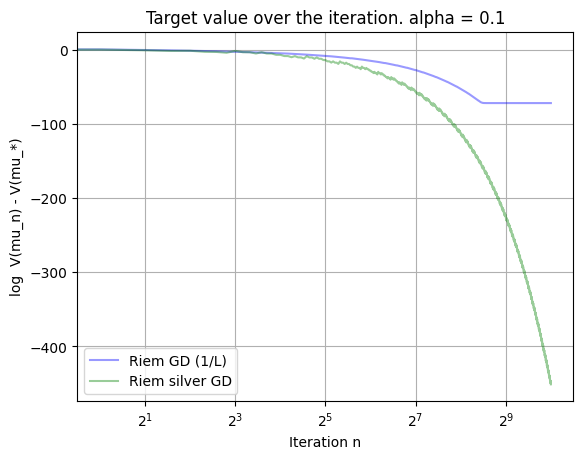

In [11]:
iterations = list(range(num_large_iter * (num_subiter+1)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green']
labels = ["Riem GD (1/L)", "Riem silver GD"] # Labels for the legend

plt.plot(iterations, gd_v_list_final, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, silver_gd_v_list_final, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)

# y0 = silver_gd_v_list_final[0]

# k = np.arange(1, len(silver_gd_v_list_final) + 1)  # n = 1..T
# y_theory = 1* y0 / (k ** np.log2(1 + np.sqrt(2)))                            # anchored at first point
# plt.plot(iterations, np.log(y_theory), linestyle='--', linewidth=2, color = 'green', alpha = 0.4,
#          label=fr'silver Theory')
# k = np.arange(1, len(gd_v_list_final) + 1)  # n = 1..T
# y_theory2 = 1* y0 / k                            # anchored at first point
# plt.plot(iterations, np.log(y_theory2), linestyle='--', linewidth=2, color = 'blue', alpha = 0.4,
#          label=fr'gd Theory')

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("log  V(mu_n) - V(mu_*)")
plt.title("Target value over the iteration. alpha = " + str(alpha))
plt.xscale('log',base=2)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Multiple experiment

Setting

In [12]:
N_runs = 100 # number of indepedent trials
seeds = range(N_runs) # seeds to experiment

Run simulations

In [ ]:
gd_runs_1l = [] # collect each run’s list stepsize of 1/L
gd_runs_2l = [] # step_sizze with 1.99/L
gd_runs_201l = [] # stepsize of 2.01/L
silver_runs = [] # silver stepsize

for seed in seeds: # outer loop for different seeds
    np.random.seed(seed) # set seeds differently for each trial

    # ——— problem setup ———
    alpha = 1e-13
    L = 1
    eps = 1e-01
    dim = 10
    mu_true = uniform.rvs(size=(dim,))
    Sigma_true = gen_matrix_with_eigs(np.geomspace(1/L, 1/alpha, dim))
    Sigma_base = uniform.rvs(size = (dim, )) * np.eye(dim)
    num_subiter = 2**10 - 1 #alpha = 1e-13->35, 1e-07 = 20, 1e-03 = 9, 1e-01 = 4
    num_large_iter = 2 ** 0 #

    # to save the last update -> for restarting
    gd_mu_last_j_1l = None
    gd_Sigma_last_j_1l = None
    gd_mu_last_j_2l = None
    gd_Sigma_last_j_2l = None
    gd_mu_last_j_201l = None
    gd_Sigma_last_j_201l = None
    silver_gd_mu_last_j = None
    silver_gd_Sigma_last_j = None

    # saving results for each seed
    gd_v_list_final_1l = []  # reset per each seed
    gd_v_list_final_2l = []
    gd_v_list_final_201l = []
    silver_gd_v_list_final = []

    # ——— experiment loop ———
    for j in range(num_large_iter):
      # 1/L
      gd_v_list_j_1l, gd_mu_last_j_1l, gd_Sigma_last_j_1l = wasser_gds(
          dim, mu_true, Sigma_true, num_subiter,
          alpha, L, step_size = 1/L,silver=False, stochastic=True,
          init_mu=gd_mu_last_j_1l, init_Sigma=gd_Sigma_last_j_1l
      )
      gd_v_list_final_1l += gd_v_list_j_1l
      # 1.99/L
      gd_v_list_j_2l, gd_mu_last_j_2l, gd_Sigma_last_j_2l = wasser_gds(
          dim, mu_true, Sigma_true, num_subiter,
          alpha, L, step_size = 1.99/L,silver=False, stochastic=True,
          init_mu=gd_mu_last_j_2l, init_Sigma=gd_Sigma_last_j_2l
      )
      gd_v_list_final_2l += gd_v_list_j_2l
      # 2.01/L
      gd_v_list_j_201l, gd_mu_last_j_201l, gd_Sigma_last_j_201l = wasser_gds(
          dim, mu_true, Sigma_true, num_subiter,
          alpha, L, step_size = 2.01/L,silver=False, stochastic=True,
          init_mu=gd_mu_last_j_201l, init_Sigma=gd_Sigma_last_j_201l
      )
      gd_v_list_final_201l += gd_v_list_j_201l
      # silver
      silver_gd_v_list_j, silver_gd_mu_last_j, silver_gd_Sigma_last_j = wasser_gds(
          dim, mu_true, Sigma_true, num_subiter,
          alpha, L, silver=True, stochastic=True,
          init_mu=silver_gd_mu_last_j,
          init_Sigma=silver_gd_Sigma_last_j
      )
      silver_gd_v_list_final += silver_gd_v_list_j

    # collect this trial’s curves
    gd_runs_1l.append(gd_v_list_final_1l)
    gd_runs_2l.append(gd_v_list_final_2l)
    gd_runs_201l.append(gd_v_list_final_201l)
    silver_runs.append(silver_gd_v_list_final)

/tmp/ipython-input-152543406.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gd_x = mvn(gd_mu_k, gd_Sigma_k, size=100)


Aggregate the result and make the statistic

In [ ]:
# We have lists of length N_runs, each an inner list of length num_subiter
gd_mat_1l     = np.array(gd_runs_1l) # shape (N_runs, num_subiter)
gd_mat_2l     = np.array(gd_runs_2l)
gd_mat_201l     = np.array(gd_runs_201l)
silver_mat = np.array(silver_runs)

# compute mean of the error curve
gd_mean_1l    = gd_mat_1l.mean(axis=0)
gd_mean_2l    = gd_mat_2l.mean(axis=0)
gd_mean_201l    = gd_mat_201l.mean(axis=0)
silver_mean = silver_mat.mean(axis=0)

# mean trend + 95% (2.5/97.5) percentile bands
gd_lo_1l, gd_hi_1l = np.percentile(gd_mat_1l, [2.5, 97.5], axis=0)
gd_lo_2l, gd_hi_2l = np.percentile(gd_mat_2l,  [2.5, 97.5], axis=0)
gd_lo_201l, gd_hi_201l = np.percentile(gd_mat_201l, [2.5, 97.5], axis=0)
silver_lo, silver_hi = np.percentile(silver_mat, [2.5, 97.5], axis=0)

Plot

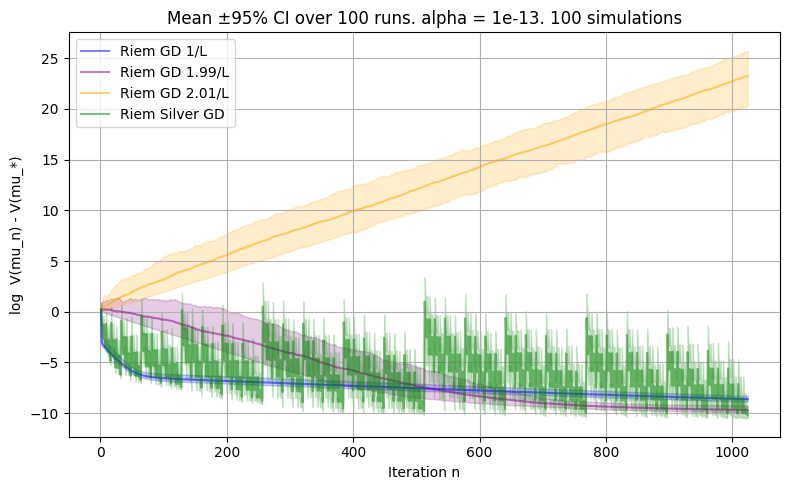

In [ ]:
# x-axis: num of iterations
T = gd_mean_1l.shape[0]
iters = np.arange(1, T+1)

# plot
plt.figure(figsize=(8,5))
plt.plot(iters, gd_mean_1l, label='Riem GD 1/L', alpha = 0.5, color = 'blue')
plt.fill_between(iters, gd_lo_1l, gd_hi_1l, alpha=0.2, color = 'blue')
plt.plot(iters, gd_mean_2l, label='Riem GD 1.99/L', alpha = 0.5, color = 'purple')
plt.fill_between(iters, gd_lo_2l, gd_hi_2l, alpha=0.2, color = 'purple')
plt.plot(iters, gd_mean_201l, label='Riem GD 2.01/L', alpha = 0.5, color = 'orange')
plt.fill_between(iters, gd_lo_201l, gd_hi_201l, alpha=0.2, color = 'orange')
plt.plot(iters, silver_mean, label='Riem Silver GD', alpha = 0.5, color = 'green')
plt.fill_between(iters, silver_lo, silver_hi, alpha=0.2, color = 'green')

# visualization
plt.xlabel("Iteration n")
plt.ylabel("log  V(mu_n) - V(mu_*)")

# plt.xscale('log',base=2)
# plt.ylim(top = np.maximum(gd_med[0], silver_med[0]))
plt.legend()
plt.title(f'Mean ±95% CI over {N_runs} runs. alpha = ' + str(alpha) + '. ' + str(N_runs) + ' simulations')
plt.tight_layout()
plt.grid(True)
plt.show()

### Logistic regression

In [72]:
def _softplus(t):
    # stable log(1 + exp(t))
    out = np.empty_like(t)
    pos = t >= 0
    out[pos]  = t[pos] + np.log1p(np.exp(-t[pos]))
    out[~pos] = np.log1p(np.exp(t[~pos]))
    return out

def softmax(x):
    """
    Univariate softmax function.
    """
    return np.exp(x) / (1 + np.exp(x))

def _sigmoid(t):
    # stable 1/(1+e^{-t})
    out = np.empty_like(t)
    pos = t >= 0
    out[pos]  = 1.0 / (1.0 + np.exp(-t[pos]))
    e = np.exp(t[~pos])
    out[~pos] = e / (1.0 + e)
    return out

def _chol_psd(Sigma, jitter=1e-10, max_tries=5):
    """Cholesky with tiny jitter fallback for near-PSD matrices."""
    L = None
    add = 0.0
    for _ in range(max_tries):
        try:
            L = np.linalg.cholesky(Sigma + add * np.eye(Sigma.shape[0]))
            break
        except np.linalg.LinAlgError:
            add = jitter if add == 0.0 else add * 10
    if L is None:
        # final fallback: symmetric eigendecomp (clips tiny negatives)
        w, V = np.linalg.eigh((Sigma + Sigma.T) * 0.5)
        w = np.clip(w, 0.0, None)
        L = V @ (np.sqrt(w)[:, None] * V.T)
    return L

def make_logistic_gaussian_moments(X, Y, *, default_N=1024, antithetic=True, batch_size=0):
    """
    Create a moments(mu, Sigma, Nsamples=None, rng=None, clip=None) function that
    returns Monte-Carlo estimates of:
      E[V(θ)], E[∇V(θ)], E[∇²V(θ)]
    for θ ~ N(mu, Sigma), where for logistic regression
      V(θ) = sum_i softplus(x_i^T θ) - y_i (x_i^T θ).

    Args:
      X: (n, d) design matrix.
      Y: (n,) binary targets in {0,1}.
      default_N: default number of MC samples if Nsamples not provided.
      antithetic: if True and N is even, use antithetic sampling z and -z.
      batch_size: if >0, process samples in batches to control memory.

    Returns:
      moments(mu, Sigma, Nsamples=None, rng=None, clip=None) -> (EV, Egrad, EHess)
        EV:    scalar
        Egrad: (d,)
        EHess: (d,d)
    """
    X = np.asarray(X, dtype=float)           # <-- force real
    y = np.asarray(Y, dtype=float)
    n, d = X.shape

    def moments(mu, Sigma, Nsamples=None, rng=None, clip=None):
        mu = np.asarray(mu, dtype=float)     # <-- force real
        Sigma = np.asarray(Sigma, dtype=float)
        assert mu.shape == (d,)
        assert Sigma.shape == (d, d)

        N = int(Nsamples) if Nsamples is not None else int(default_N)
        if N <= 0:
            raise ValueError("Nsamples must be positive.")

        # Cholesky (or PSD fallback)
        L = _chol_psd(Sigma)

        # RNG
        if rng is None:
            rng = np.random.default_rng()

        # If antithetic is requested, make N even and pair samples
        use_antithetic = antithetic and (N % 2 == 0)
        halfN = N // 2 if use_antithetic else N

        # batching
        B = batch_size if (batch_size and batch_size > 0) else halfN

        EV_sum = 0.0
        Egrad_sum = np.zeros(d, dtype=float)
        EHess_sum = np.zeros((d, d), dtype=float)
        total = 0

        def process_theta(Theta):
            # Theta: (m, d)
            T = Theta @ X.T            # (m, n) logits per sample
            if clip is not None:
                T = np.clip(T, -clip, clip)
            s = _sigmoid(T)            # (m, n)
            sp = _softplus(T)          # (m, n)

            # V(θ) per sample: sum softplus - y^T (Xθ)
            V_per = sp.sum(axis=1) - (T @ y)
            # ∇V(θ) per sample: X^T(σ - y)
            G_per = (s - y) @ X        # (m, d)

            # ∇²V(θ) per sample: X^T diag(σ(1-σ)) X
            w = s * (1.0 - s)          # (m, n)
            # Weighted Gram per sample: sum_i w_i x_i x_i^T
            # Do this by scaling rows of X and forming X^T (W * X)
            H_acc = np.zeros((Theta.shape[0], d, d))
            # vectorized trick: for each sample j, (X * w_j[:,None]).T @ X
            # We do it in a loop over the batch for memory friendliness.
            for j in range(Theta.shape[0]):
                Xw = X * w[j][:, None]        # (n, d)
                H_acc[j] = X.T @ Xw           # (d, d)

            return V_per, G_per, H_acc

        # Generate and process in batches
        remaining = halfN
        while remaining > 0:
            m = min(B, remaining)
            Z = rng.standard_normal((m, d))
            Theta = mu + Z @ L.T
            V_per, G_per, H_acc = process_theta(Theta)

            if use_antithetic:
                Theta_bar = mu - Z @ L.T
                V_per2, G_per2, H_acc2 = process_theta(Theta_bar)

                EV_sum += V_per.sum() + V_per2.sum()
                Egrad_sum += G_per.sum(axis=0) + G_per2.sum(axis=0)
                EHess_sum += H_acc.sum(axis=0) + H_acc2.sum(axis=0)
                total += 2 * m
            else:
                EV_sum += V_per.sum()
                Egrad_sum += G_per.sum(axis=0)
                EHess_sum += H_acc.sum(axis=0)
                total += m

            remaining -= m

        # Averages over all samples
        EV = EV_sum / total
        Egrad = Egrad_sum / total
        EHess = EHess_sum / total
        return EV, Egrad, EHess

    return moments


In [95]:
def wasser_gds_logit(dim, logit_gaussian_moment_ftn, num_iter, L, silver = True, init_mu = None, init_Sigma = None):
  """
  Conduct GD for KL(\mu || \pi) = V(\mu) + H(\mu)
  """
  # create a list to save the result
  gd_V_list = []
  # create a step-size list
  stepsize_list = []
  rho = math.sqrt(2) + 1

  # initialize
  if init_mu is None:
    gd_mu_k = np.zeros(dim)
  else:
    gd_mu_k = init_mu
  if init_Sigma is None:
    gd_Sigma_k = np.eye(dim)
  else:
    gd_Sigma_k = init_Sigma

  # save the initial result: log error
  EV, _, _ = logit_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
  gd_V_list.append(EV)

  # run the gradient methods
  for curr_iter in range(num_iter):
    # calculate gradient
    EV, gd_nabla_1, gd_nabla_2 = logit_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
    # compute stepsize
    if silver:
      stepsize = (1 + rho**(((curr_iter+1) & -(curr_iter+1)).bit_length()-2))/L
    else:
      stepsize = 1/L
    # one step update
    gd_mu_k, gd_Sigma_k = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, stepsize, dim)

    # save the initial result: log error
    EV, _, _ = logit_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
    gd_V_list.append(EV)

  # save the last result
  gd_mu_last = gd_mu_k
  gd_Sigma_last = gd_Sigma_k

  # return the result
  return gd_V_list, gd_mu_last, gd_Sigma_last

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3364346700.py:3: SyntaxWarning: invalid escape sequence '\m'
  Conduct GD for KL(\mu || \pi) = V(\mu) + H(\mu)


Synthetic data generation

In [108]:
np.random.seed(1234)

num_sample, dim = 20, 10
X = mvn(np.zeros(dim), np.eye(dim), size=(num_sample))    # (n, d)
# optional global scaling (keeps conditioning manageable)
maxeig = np.linalg.eigvalsh(X.T @ X).max()
X = X / np.sqrt(maxeig)
true_theta = mvn(np.zeros(dim), np.eye(dim))                 # (d,)
probs = softmax(X @ true_theta)
Y = bernoulli.rvs(probs)

logit_gaussian_moment_ftn = make_logistic_gaussian_moments(X, Y, default_N = 100)

In [109]:
L = 1/4
num_subiter = 2 ** 10 - 1 #alpha = 1e-13->35, 1e-07 = 20, 1e-03 = 9, 1e-01 = 4
num_large_iter = 2 ** 0
gd_mu_last_j = None
gd_Sigma_last_j = None
gd_mu_last_j_large = None
gd_Sigma_last_j_large = None
silver_gd_mu_last_j = None
silver_gd_Sigma_last_j = None
gd_v_list_final = []
gd_v_list_final_large = []
silver_gd_v_list_final = []
# run experiment
for j in range(num_large_iter):
  gd_v_list_j, gd_mu_last_j, gd_Sigma_last_j = wasser_gds_logit(
      dim, logit_gaussian_moment_ftn, num_subiter, L, silver = False, init_mu = gd_mu_last_j, init_Sigma = gd_Sigma_last_j
      )
  gd_v_list_final+= gd_v_list_j
  silver_gd_v_list_j, silver_gd_mu_last_j, silver_gd_Sigma_last_j = wasser_gds_logit(
      dim, logit_gaussian_moment_ftn, num_subiter, L, silver = True, init_mu = silver_gd_mu_last_j, init_Sigma = silver_gd_Sigma_last_j
      )
  silver_gd_v_list_final+=silver_gd_v_list_j

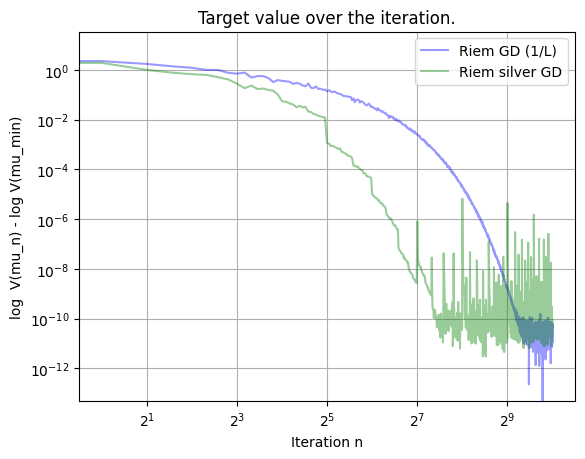

In [110]:
iterations = list(range(num_large_iter * (num_subiter+1)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green']
labels = ["Riem GD (1/L)", "Riem silver GD"] # Labels for the legend

min_value_gd = np.min(gd_v_list_final)
min_value_silver = np.min(silver_gd_v_list_final)
min_value = min(min_value_gd,min_value_silver)

plt.plot(iterations, gd_v_list_final - min_value, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, silver_gd_v_list_final - min_value, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)

# y0 = silver_gd_v_list_final[0]

# k = np.arange(1, len(silver_gd_v_list_final) + 1)  # n = 1..T
# y_theory = 1* y0 / (k ** np.log2(1 + np.sqrt(2)))                            # anchored at first point
# plt.plot(iterations, np.log(y_theory), linestyle='--', linewidth=2, color = 'green', alpha = 0.4,
#          label=fr'silver Theory')
# k = np.arange(1, len(gd_v_list_final) + 1)  # n = 1..T
# y_theory2 = 1* y0 / k                            # anchored at first point
# plt.plot(iterations, np.log(y_theory2), linestyle='--', linewidth=2, color = 'blue', alpha = 0.4,
#          label=fr'gd Theory')

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("log  V(mu_n) - log V(mu_min)")
plt.title("Target value over the iteration.")
plt.xscale('log',base=2)
plt.yscale('log')
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Task 3: Two-layer neural net mean-field training

### Basic modules

In [14]:
# define the data and the network
class TwoLayerNet(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.hidden = nn.Linear(1, m)
        self.relu   = nn.ReLU()
        self.output = nn.Linear(m, 1, bias=False)
    def forward(self, x):
        return self.output(self.relu(self.hidden(x)))

def make_data(f_star, N=200, train_portion=0.7, seed=0):
    """
    Generate train/val/test splits for any target f_star.
    Returns torch tensors: X_train, y_train, X_val, y_val, X_test, y_test
    """
    np.random.seed(seed)
    X = np.random.uniform(-1, 1, N)
    y = f_star(X)  # use the arbitrary target function
    idx = np.random.permutation(N) # mix the indices for training and testing
    n_train = int(train_portion * N)

    def slice_range(i0, i1):
        Xi = X[idx[i0:i1]].reshape(-1, 1)
        yi = y[idx[i0:i1]].reshape(-1, 1)
        return Xi, yi

    Xtr, ytr = slice_range(0, n_train)
    Xte, yte = slice_range(n_train, N)

    # convert to torch tensors
    return (
        torch.tensor(Xtr, dtype=torch.float32),
        torch.tensor(ytr, dtype=torch.float32),
        torch.tensor(Xte, dtype=torch.float32),
        torch.tensor(yte, dtype=torch.float32),
    )


Generate the true data

In [15]:
# Choose the target function

# Choice 1: sin(2\pi x)
def f_star_np(x):
    return np.sin(2 * np.pi * x)

# Choice 2: shallow neural network
# l = 30
# w = np.random.randn(l, 1)
# b = np.random.randn(l, 1)
# a = np.random.randn(l)

# def f_star_np(x):
#     """
#     f^*(x) = (1/l) * sum_i a_i * ReLU(w_i^T x + b_i)
#     """
#     z = w * x + b
#     relu_z = np.maximum(0, z) # ReLU
#     # weight & average across the l hidden units
#     fx = (a[:,None] * relu_z).sum(axis=0) / l
#     return fx


# train with different step-sizes
def train_with_schedule(step_size_fn, num_iters=1000, m=50, seed=0):
    torch.manual_seed(seed)
    X_train, y_train, X_test, y_test = make_data(f_star = f_star_np, seed=seed)
    model = TwoLayerNet(m)
    criterion = nn.MSELoss()

    train_losses, test_losses = [], []
    for t in range(1, num_iters+1):
        s = step_size_fn(t)
        # forward & backward
        pred = model(X_train)
        loss = criterion(pred, y_train)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= s * p.grad
        # record
        train_losses.append(loss.item())
        with torch.no_grad():
            test_losses.append(criterion(model(X_test), y_test).item())

    return train_losses, test_losses, model

Conduct the experiment

In [16]:
rho = 1+math.sqrt(2)

# Different step-size schedules
L = 100 # Fix the smoothness parameter
schedules = {
    "1/L": lambda t: 1/L,
    "2/L": lambda t: 2/L,
    "4/L": lambda t: 4/L,
    "silver": lambda t: ((1 + rho**(((t+1) & -(t+1)).bit_length()-2)) / L) # silver step-size
}

# Run experiments
results = {}
models  = {}
for name, fn in schedules.items():
    tr, te, net = train_with_schedule(fn, num_iters=2000, m = 100, seed = 0)
    results[name] = (tr, te)
    models[name] = net

Plot error trajactory

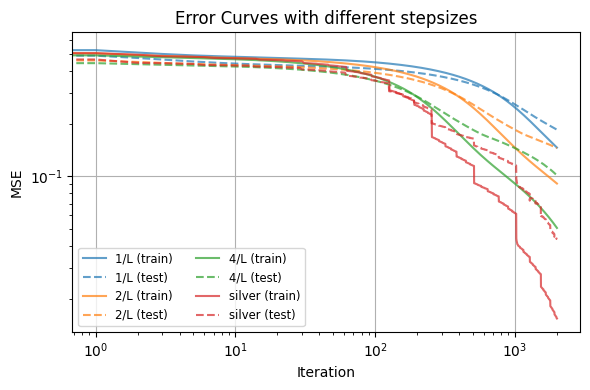

In [17]:
# plot the error over iterations
plt.figure(figsize=(6,4))
for name, (tr, te) in results.items():
    line, = plt.plot(tr, label=f"{name} (train)", alpha=0.7)
    color = line.get_color()
    plt.plot(te, "--", label=f"{name} (test)", alpha = 0.7, color=color)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Error Curves with different stepsizes")
plt.xscale('log',base=10)
plt.yscale('log',base=10)
plt.legend(fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


Plot function graph

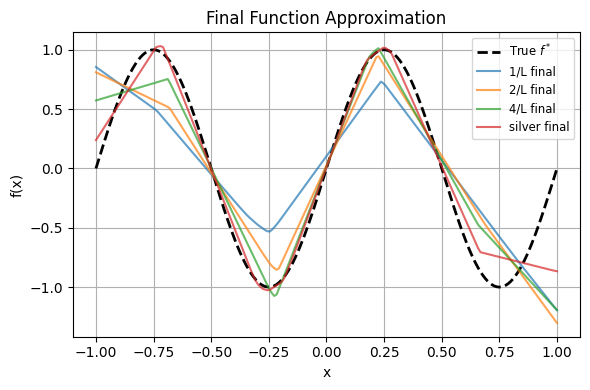

In [18]:
# plot the function graph
x_grid = np.linspace(-1, 1, 200)
y_true = f_star_np(x_grid)

plt.figure(figsize=(6,4))
plt.plot(x_grid, y_true, 'k--', linewidth=2, label="True $f^*$")

for name, net in models.items():
    with torch.no_grad():
        y_pred = net(torch.from_numpy(x_grid.reshape(-1,1)).float())\
                     .numpy().flatten()
    plt.plot(x_grid, y_pred, '-',label=f"{name} final", alpha = 0.7)

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Final Function Approximation")
plt.legend(fontsize="small")
plt.tight_layout()
plt.grid(True)
plt.show()

### Log det function

### SPD with Pseudo Huber-loss

In [21]:
def logdet_spd(A):
    """Stable logdet for SPD via slogdet (assumes A ≻ 0)."""
    sign, ld = np.linalg.slogdet(A)
    if sign <= 0:
        raise ValueError("logdet_spd: matrix not SPD (non-positive determinant).")
    return ld

# --------- Pseudo-Huber on u = logdet(A) - τ ---------
def phi_pseudo_huber(u, delta=1.0):
    """
    φ(u) = δ^2 ( sqrt(1 + (u/δ)^2) - 1 )
    Convex, C^2, L-smooth with L = 1 (in 1D).
    """
    u_over_d = u / delta
    return (delta**2) * (np.sqrt(1.0 + u_over_d * u_over_d) - 1.0)

def dphi_pseudo_huber(u, delta=1.0):
    """φ'(u) = u / sqrt(1 + (u/δ)^2)."""
    u_over_d = u / delta
    return u / np.sqrt(1.0 + u_over_d * u_over_d)

# --------- f(A) = φ(logdet(A) - τ) ---------
def f_pseudo_huber(A, tau=0.0, delta=1.0):
    """Value of f(A) = φ(logdet(A) - τ). Assumes A is SPD."""
    u = logdet_spd(A) - tau
    return phi_pseudo_huber(u, delta)

def grad_airm_pseudo_huber(A, tau=0.0, delta=1.0):
    """
    AIRM (affine-invariant) Riemannian gradient:
        ∇ f(A) = φ'(u) * A,  where u = logdet(A) - τ.
    """
    u = logdet_spd(A) - tau
    c = dphi_pseudo_huber(u, delta)
    return c * A

def step_airm_pseudo_huber(A, eta, tau=0.0, delta=1.0):
    """
    One Riemannian GD step with stepsize η:
        A_{+} = Exp_A( -η ∇f(A) ) = exp( -η φ'(u) ) * A
    (Closed form because ∇f(A) ∝ A.)
    """
    u = logdet_spd(A) - tau
    c = dphi_pseudo_huber(u, delta)  # scalar
    scale = np.exp(-eta * c)
    return scale * A

In [22]:
def entropy_gds_huber(spd_mfd, num_iter, L, step_size=1, init_x = None, silver=False, base = None, target_value = 0, delta = 1):
  # create a list to save the result
  gd_f_list = []

  rho = 1 + math.sqrt(2)

  # initialize
  if init_x is None:
    gd_x_k = spd_mfd.random_point()
  else:
    gd_x_k = init_x

  # save the initial result
  # current_gd_f = -0.5*np.dot(gd_x_k, np.dot(H, gd_x_k))
  # current_gd_f = -np.linalg.slogdet(gd_x_k)[1]
  # current_gd_f = 0.5 * (np.linalg.slogdet(gd_x_k)[1] - target_value)**2
  current_gd_f = f_pseudo_huber(gd_x_k, tau = target_value, delta = delta)
  gd_f_list.append(current_gd_f)

  # run the gradient methods
  for curr_iter in range(num_iter):
    # calculate gradient
    # gd_grad = spd_mfd.euclidean_to_riemannian_gradient(gd_x_k, -0.5 * gd_x_k)
    # gd_grad = -gd_x_k
    # gd_grad = ((np.linalg.slogdet(gd_x_k)[1] - target_value)) * gd_x_k
    gd_grad = grad_airm_pseudo_huber(gd_x_k, tau = target_value, delta = delta)
    # gradient update
    if silver:
      stepsize = (1 + rho**(((curr_iter+1) & -(curr_iter+1)).bit_length()-2))/L
      # stepsize = eta(curr_iter)/L
    else:
      stepsize = step_size
    # one step update
    if base is None:
      # gd_x_k = spd_mfd.exp(gd_x_k, -stepsize * gd_grad)
      gd_x_k = step_airm_pseudo_huber(gd_x_k, stepsize, tau = target_value, delta = delta)
      # gd_x_k = np.exp(-stepsize*(np.linalg.slogdet(gd_x_k)[1] - 1))*gd_x_k
    else:
      transported_grad = spd_mfd.transport(gd_x_k, base, gd_grad)
      base_pt_grad = spd_mfd.log(base, gd_x_k) - stepsize * transported_grad
      gd_x_k = spd_mfd.exp(base, base_pt_grad)
    # save the result
    # current_gd_f = -np.linalg.slogdet(gd_x_k)[1]
    # current_gd_f = 0.5 * (np.linalg.slogdet(gd_x_k)[1] - target_value)**2
    current_gd_f = f_pseudo_huber(gd_x_k, tau = target_value, delta = delta)
    gd_f_list.append(current_gd_f)

  # save the last result
  gd_x_last = gd_x_k

  # return the result
  return gd_f_list, gd_x_last

In [23]:
np.random.seed(123)
d = 50 #problem dimension
spd_mfd = SymmetricPositiveDefinite(n = d)

L_0 = 1.0 * d
L_1 = np.sqrt(2) * d
num_subiter = 2**7 - 1
num_large_iter = 2 ** 0
init_value = spd_mfd.random_point()
gd_x_last_j = init_value
silver_gd_x_last_j = init_value
base_value = 1 * np.eye(d)
# base_value = spd_mfd.random_point()
gd_f_list_final = []
silver_gd_f_list_final = []
# run experiment
for j in range(num_large_iter):
  gd_f_list_j, gd_x_last_j = entropy_gds_huber(spd_mfd, num_subiter, L_0, 1.0/L_0, init_x = gd_x_last_j, silver=False, target_value = 0, delta = 0.1)
  gd_f_list_final+= gd_f_list_j
  # print("gd_done")
  silver_gd_f_list_j, silver_gd_x_last_j = entropy_gds_huber(spd_mfd, num_subiter, L_1, init_x = silver_gd_x_last_j, silver=True, base = None, target_value = 0, delta = 0.1)
  silver_gd_f_list_final+=silver_gd_f_list_j
  # print("silver_done")

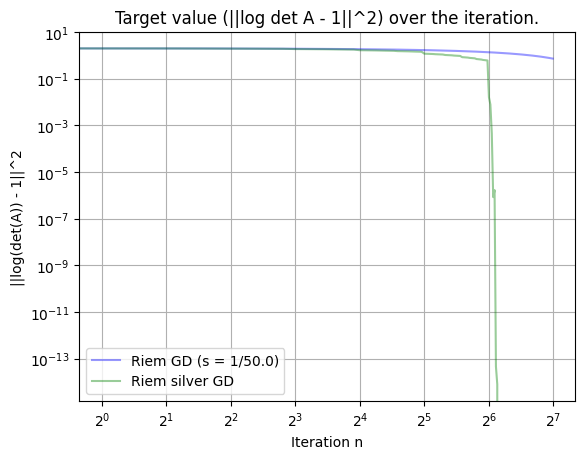

In [24]:
iterations = list(range(num_large_iter * (num_subiter+1)))  # Create the x-axis (iteration numbers)

# Define distinct colors for the lines
colors = ['blue', 'green']
labels = [f"Riem GD (s = 1/{L_0})", f"Riem silver GD"] # Labels for the legend

plt.plot(iterations, gd_f_list_final, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, silver_gd_f_list_final, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("||log(det(A)) - 1||^2")
plt.title("Target value (||log det A - 1||^2) over the iteration.")
# plt.title("Target value over the iteration. (max_eig, min_eig) = (" + str(max_eig) + ", " + str(min_eig) + ")")
plt.xscale('log',base=2)
plt.yscale('log',base=10)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [32]:
# Parameters
d = 50
num_seeds = 10  # number of random seeds
base_seed = 100
num_iter = 2**7 - 1
iterations = np.arange(num_iter + 1)
methods = ['RGD (1/L)', 'silver']
errors = {m: np.zeros((num_seeds, len(iterations))) for m in methods}
L_0 = d
L_1 = np.sqrt(2) * d
delta = 1

In [33]:
# Run simulations
# base_value = np.eye(d)
for i in range(num_seeds):
    seed = base_seed + i
    np.random.seed(seed)
    init_x = spd_mfd.random_point()

    # Step-size = 1/L
    flist, _ = entropy_gds_huber(spd_mfd, num_subiter, L_0, 1/L_0, init_x = init_x, silver=False, target_value = 1, delta = delta)
    errors['RGD (1/L)'][i] = np.array(flist)

    # Silver step-size
    flist, _ = entropy_gds_huber(spd_mfd, num_subiter, L_1, 1/L_1, init_x = init_x, silver=True, base = None, target_value = 1, delta = delta)
    errors['silver'][i] = np.array(flist)

# Compute mean and 95% CI by quantiles
# mean_err = {m: errors[m].mean(axis=0) for m in methods}
median_err = {m: np.quantile(errors[m], 0.5, axis=0) for m in methods}
lower_err = {m: np.quantile(errors[m], 0.025, axis=0) for m in methods}
upper_err = {m: np.quantile(errors[m], 0.975, axis=0) for m in methods}

###

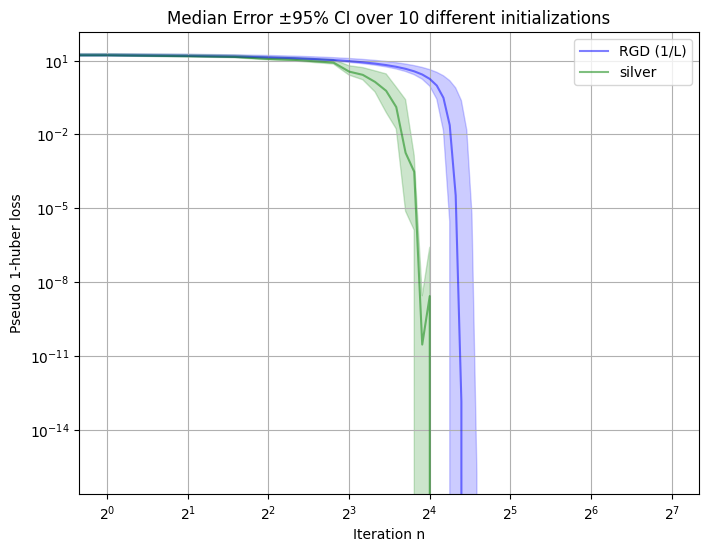

In [34]:
# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i, m in enumerate(methods):
    plt.plot(iterations, median_err[m], label=m, alpha = 0.5, color = colors[i])
    plt.fill_between(iterations, lower_err[m], upper_err[m], alpha=0.2, color = colors[i])
plt.xlabel("Iteration n")
plt.ylabel(f"Pseudo {delta}-huber loss")
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.title(f"Median Error ±95% CI over {num_seeds} different initializations")
plt.legend()
plt.grid(True)
plt.show()

### Gaussian Mixture

In [36]:
# ---------- utilities on SPD with the affine-invariant metric ----------
def _sym(A):
    return 0.5 * (A + A.T)

def spd_eig_sqrt_invsqrt(S):
    """Return S^{1/2} and S^{-1/2} via symmetric eigendecomposition."""
    w, U = np.linalg.eigh(_sym(S))
    w = np.clip(w, 1e-12, None)
    S12  = (U * np.sqrt(w)) @ U.T
    Si12 = (U * (1.0 / np.sqrt(w))) @ U.T
    return S12, Si12

def expm_sym(A):
    """Matrix exponential for symmetric A via eigendecomposition."""
    w, U = np.linalg.eigh(_sym(A))
    return (U * np.exp(w)) @ U.T

def softmax(logits):
    z = logits - logits.max()  # stability
    e = np.exp(z)
    return e / e.sum()

def log_softmax(logits):
    z = logits - logits.max()
    logZ = np.log(np.exp(z).sum())
    return z - logZ

In [37]:
# ---------- Gaussian pieces ----------
def log_gauss_0(y, S):
    """
    log N(y; 0, S) for many y with a single covariance S.
    y: (m, d), S: (d, d)
    returns: (m,)
    """
    L = np.linalg.cholesky(_sym(S))              # S = L L^T
    # solve L z = y  -> z = L^{-1} y; then y^T S^{-1} y = ||z||^2
    z = np.linalg.solve(L, y.T)                  # shape (d, m)
    quad = np.sum(z**2, axis=0)
    logdetS = 2.0 * np.sum(np.log(np.diag(L)))
    d = y.shape[1]
    return -0.5 * (d * np.log(2.0*np.pi) + logdetS + quad)

# ---------- core: objective, responsibilities, gradients ----------
def mixture_loglik_eta_S(Y, etas, S_list):
    """
    Compute f(etas, S_list) = sum_i log sum_j pi_j N(0, S_j)(y_i).
    Y: (m, d)
    etas: (K,)
    S_list: list/array of K SPD matrices of shape (d, d)
    """
    K = len(S_list)
    m = Y.shape[0]

    log_pi = log_softmax(etas)                   # (K,)
    log_q = np.stack([log_gauss_0(Y, S_list[j]) for j in range(K)], axis=1)  # (m,K)
    # log-sum-exp over j
    log_mix = log_q + log_pi[None, :]            # (m, K)
    # stable logsumexp
    a = log_mix.max(axis=1, keepdims=True)
    f = np.sum(a + np.log(np.exp(log_mix - a).sum(axis=1, keepdims=True)))
    return float(f)

def responsibilities(Y, etas, S_list):
    """
    Return responsibilities r_{ij}, mixture weights pi, and per-component log-densities.
    r: (m, K), pi: (K,), log_q: (m, K)
    """
    K = len(S_list)
    log_pi = log_softmax(etas)                   # (K,)
    log_q = np.stack([log_gauss_0(Y, S_list[j]) for j in range(K)], axis=1)  # (m,K)
    log_mix = log_q + log_pi[None, :]            # (m,K)
    # posterior responsibilities r_{ij} = softmax_j(log_mix_{ij})
    a = log_mix.max(axis=1, keepdims=True)
    r = np.exp(log_mix - a)
    r = r / r.sum(axis=1, keepdims=True)
    pi = np.exp(log_pi)
    return r, pi, log_q

def gradients_eta_S(Y, etas, S_list):
    """
    Euclidean grad wrt etas, and Riemannian grad (AIRM) wrt each S_j.
    Returns: grad_eta (K,), gradR_S_list (list of K (d,d) matrices)
    """
    r, pi, _ = responsibilities(Y, etas, S_list)
    m, d = Y.shape
    K = len(S_list)

    # ---- grad wrt etas (Euclidean): sum_i (r_ij - pi_j)
    Nk = r.sum(axis=0)                   # (K,)
    grad_eta = Nk - m * pi               # ascent direction

    # ---- grad wrt S_j (Riemannian/AIRM): 0.5 * (C_j - m_j S_j)
    gradR_S = []
    for j in range(K):
        w = r[:, j][:, None]             # (m,1)
        Cj = Y.T @ (w * Y)               # sum_i r_ij y_i y_i^T  (d,d)
        mj = Nk[j]
        gradR = 0.5 * (Cj - mj * S_list[j])
        gradR_S.append(_sym(gradR))
    return grad_eta, gradR_S

# ---------- one update step ----------
def step_eta_S(Y, etas, S_list, step_eta=1e-2, step_S=1e-2, fix_last_logit=False, base = False):
    """
    Perform ONE gradient-ascent step:
      - Euclidean step on etas
      - Riemannian (AIRM) exponential step on each S_j
    Args:
        Y: (m,d)
        etas: (K,)
        S_list: list of K SPD (d,d) matrices
        step_eta: stepsize for etas
        step_S:   stepsize for S_j
        fix_last_logit: if True, keep etas[-1] fixed (useful to anchor softmax)
    Returns:
        etas_new, S_list_new, f_before, f_after
    """
    f_before = mixture_loglik_eta_S(Y, etas, S_list)
    grad_eta, gradR_S = gradients_eta_S(Y, etas, S_list)

    # ---- eta update (Euclidean ascent) ----
    etas_new = etas + step_eta * grad_eta
    if fix_last_logit:
        etas_new[-1] = 0.0  # anchor

    # ---- S update (AIRM ascent) ----
    S_new = []
    # we need C_j and m_j again to build the closed-form exp update efficiently
    r, _, _ = responsibilities(Y, etas, S_list)
    Nk = r.sum(axis=0)  # (K,)
    for j, S in enumerate(S_list):
        # build A = (step_S/2)*(S^{-1/2} C_j S^{-1/2} - m_j I)
        w = r[:, j][:, None]
        Cj = Y.T @ (w * Y)                     # (d,d)
        if base is False:
          S12, Si12 = spd_eig_sqrt_invsqrt(S)
          A = (step_S / 2.0) * (Si12 @ Cj @ Si12 - Nk[j] * np.eye(S.shape[0]))
          S_next = S12 @ expm(A) @ S12       # Exp_S( step_S * gradR )
        else:
          _, Si12 = spd_eig_sqrt_invsqrt(S)                      # S^{-1/2}
          G = (step_S / 2.0) * (Si12 @ Cj @ Si12 - Nk[j] * np.eye(S.shape[0]))
          logS = logm(S)
          S_next = expm(logS + G)
        S_new.append(_sym(S_next))

    f_after = mixture_loglik_eta_S(Y, etas_new, S_new)
    return etas_new, S_new, f_before, f_after

# ---------- simple synthetic data ----------
def simulate_y(m=500, d=3, K_true=3, seed=0):
    """
    Generate y_i from a zero-mean Gaussian mixture with random SPD covariances.
    Returns Y (m,d), true_weights (K_true,), true_covs (list of K_true (d,d))
    """
    rng = np.random.default_rng(seed)
    w_true = rng.random(K_true)
    w_true = w_true / w_true.sum()

    covs = []
    for _ in range(K_true):
        A = rng.normal(size=(d, d))
        S = A @ A.T + 0.5 * np.eye(d)          # SPD with a bit of conditioning
        covs.append(_sym(S))

    # sample component indices
    idx = rng.choice(K_true, size=m, p=w_true)
    Y = np.zeros((m, d))
    for k in range(K_true):
        L = np.linalg.cholesky(covs[k])
        sel = (idx == k)
        Z = rng.normal(size=(sel.sum(), d))
        Y[sel] = Z @ L.T
    return Y, w_true, covs

In [38]:
# 1) Make synthetic data
Y, w_true, covs_true = simulate_y(m=100, d=2, K_true=3, seed=123)

# 2) Initialize parameters (K must match your chosen model)
K = 5
gd_etas = np.zeros(K)             # logits; you can also randomize
gd_S_list = [np.eye(Y.shape[1]) for _ in range(K)]
silver_etas = np.zeros(K)             # logits; you can also randomize
silver_S_list = [np.eye(Y.shape[1]) for _ in range(K)]

# 3) Evaluate the objective
f0 = -mixture_loglik_eta_S(Y, gd_etas, gd_S_list)
print("initial f =", f0)

num_iter = 2**10 - 1
L = 20

initial f = 316.87725519971326


In [39]:
# 4) Do a few gradient-ascent steps
gd_f_list = []
for t in range(num_iter):
    curr_f = -mixture_loglik_eta_S(Y, gd_etas, gd_S_list)
    gd_f_list.append(curr_f)
    gd_etas, gd_S_list, gd_f_before, gd_f_after = step_eta_S(
        Y, gd_etas, gd_S_list, step_eta=1/L, step_S=1/L, fix_last_logit=True, base = False
    )
print("final f =", -gd_f_after)

final f = 309.44283445060904


In [40]:
# 4) Do a few gradient-ascent steps
silver_f_list = []
rho = 1 + np.sqrt(2)
for t in range(num_iter):
    curr_f = -mixture_loglik_eta_S(Y, silver_etas, silver_S_list)
    silver_f_list.append(curr_f)
    stepsize = (1 + rho**(((t+1) & -(t+1)).bit_length()-2))/L
    silver_etas, silver_S_list, silver_f_before, silver_f_after = step_eta_S(
        Y, silver_etas, silver_S_list, step_eta=stepsize, step_S=stepsize, fix_last_logit=True, base = True
    )
print("final f =", -silver_f_after)

final f = 309.44283445060796


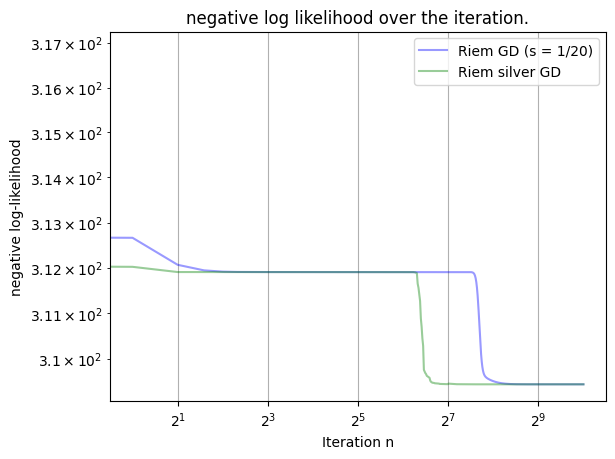

In [41]:
iterations = list(range(num_iter))  # Create the x-axis (iteration numbers)

# Define distinct colors for the lines
colors = ['blue', 'green']
labels = [f"Riem GD (s = 1/{L})", f"Riem silver GD"] # Labels for the legend

plt.plot(iterations, gd_f_list, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, silver_f_list, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("negative log-likelihood")
plt.title("negative log likelihood over the iteration.")
# plt.title("Target value over the iteration. (max_eig, min_eig) = (" + str(max_eig) + ", " + str(min_eig) + ")")
plt.xscale('log',base=2)
plt.yscale('log',base=10)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

### Trace + log det

In [42]:
def logdet_linear(X, C):
  return np.trace(X @ C) - np.linalg.slogdet(X)[1]

In [43]:
alpha = 1e5
C = gen_matrix_with_eigbounds(1/alpha, 1, dim = 50)

In [44]:
gd_f_list = []
silver_f_list = []
rho = 1 + np.sqrt(2)

num_iter = 2**7 - 1
L = 2
gd_X = np.eye(50)
silver_X = np.eye(50)
for t in range(num_iter):
  gd_curr_f = logdet_linear(gd_X, C)
  silver_curr_f = logdet_linear(silver_X, C)
  gd_f_list.append(gd_curr_f)
  silver_f_list.append(silver_curr_f)
  stepsize = (1 + rho**(((t+1) & -(t+1)).bit_length()-2))/L
  gd_x_sqrt = sqrtm(gd_X)
  gd_X = gd_x_sqrt @ expm(-(1/L) * (gd_x_sqrt @ C @ gd_x_sqrt - np.eye(50))) @ gd_x_sqrt
  silver_x_sqrt = sqrtm(silver_X)
  silver_X = expm(logm(silver_X) - stepsize *(silver_x_sqrt @ C @ silver_x_sqrt - np.eye(50))) # VTRGD with base I
  # silver_X = silver_x_sqrt @ expm(-stepsize * (silver_x_sqrt @ C @ silver_x_sqrt - np.eye(50))) @ silver_x_sqrt

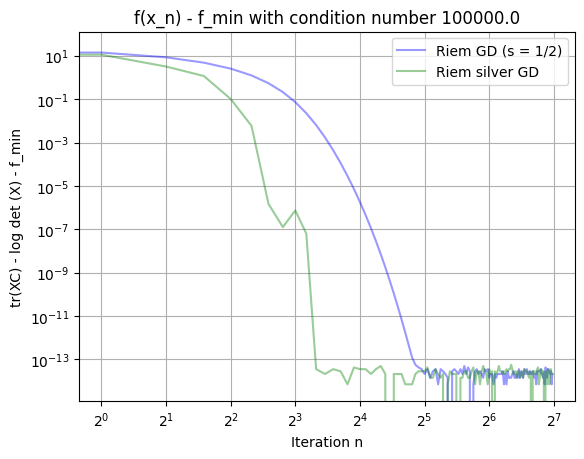

In [45]:
iterations = list(range(num_iter))  # Create the x-axis (iteration numbers)

# Define distinct colors for the lines
colors = ['blue', 'green']
labels = [f"Riem GD (s = 1/{L})", f"Riem silver GD"] # Labels for the legend

min_1 = np.min(gd_f_list)
min_2 = np.min(silver_f_list)
min_f = min(min_1, min_2)

plt.plot(iterations, gd_f_list - min_f, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, silver_f_list - min_f, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("tr(XC) - log det (X) - f_min")
plt.title(f"f(x_n) - f_min with condition number {alpha}")
# plt.title("Target value over the iteration. (max_eig, min_eig) = (" + str(max_eig) + ", " + str(min_eig) + ")")
plt.xscale('log',base=2)
plt.yscale('log',base=10)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

### Barycenter problem

In [46]:
!pip install geomstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 77.9 MB/s eta 0:00:00


In [51]:
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.spd_matrices import SPDMatrices
import matplotlib.pyplot as plt
import numpy as np
import math

Hadamard space

In [52]:
def compute_squared_loss_hadamard(hadamard_mfd, point_list, x):
  loss = 0
  for n, point in enumerate(point_list):
    loss += hadamard_mfd.metric.squared_dist(point, x).item()
  return loss / (2)

In [53]:
def enforce_spd(S, eps=1e-19):
    """Project a symmetric matrix to SPD by eigenvalue flooring."""
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)                 # symmetric eigendecomp is most stable
    # scale-aware floor: keeps conditioning sane without over-regularizing
    # floor = max(eps, 1e-12 * max(1.0, np.max(np.abs(w))))
    w_clipped = np.clip(w, eps, None)
    return (V * w_clipped) @ V.T

In [54]:
def frechet_mean_hadamard(hadamard_mfd, point_list, num_iter, L,
                          step_size=1, init_x = None, silver = True, base = None):
  """
  Conduct GD for Frechet mean in hadamard manifold
  """
  # create a list to save the result
  gd_f_list = []
  rho = 1 + np.sqrt(2)

  # initialize
  if init_x is None:
    gd_x_k = hadamard_mfd.random_point()
  else:
    gd_x_k = init_x

  # save the initial result
  current_gd_f = compute_squared_loss_hadamard(hadamard_mfd, point_list, gd_x_k)
  gd_f_list.append(current_gd_f)

  # run the gradient methods
  for curr_iter in range(2, num_iter + 1):
    # calculate gradient
    gd_grad = 0 * gd_x_k
    for point in point_list:
      gd_grad -= hadamard_mfd.metric.log(point, gd_x_k)
    if not silver:
      gd_x_k = hadamard_mfd.metric.exp(-step_size * gd_grad, gd_x_k)
    else:
      stepsize = (1 + rho**(((t+1) & -(t+1)).bit_length()-2))/L
      if base is not None:
        tp_grad = hadamard_mfd.metric.parallel_transport(
            tangent_vec = gd_grad,  base_point = gd_x_k, end_point = base
          )
        log_diff = hadamard_mfd.metric.log(point = gd_x_k, base_point = base)
        gd_x_k = hadamard_mfd.metric.exp(log_diff - stepsize * tp_grad, base)
      else:
        gd_x_k = hadamard_mfd.metric.exp(-stepsize * gd_grad, gd_x_k)
      ## TODO
    # save the result
    current_gd_f = compute_squared_loss_hadamard(hadamard_mfd, point_list, gd_x_k)
    gd_f_list.append(current_gd_f)

  # save the last result
  gd_x_last = gd_x_k

  # return the result
  return gd_f_list, gd_x_last

In [59]:
np.random.seed(123)
d = 10 #problem dimension
n = 100 #number of matrices to average
hadamard_mfd = SPDMatrices(d)
# hadamard_mfd = Hyperboloid(d)
mfd_point_list = []
for i in range(n):
  mfd_point_list.append(hadamard_mfd.random_point())

In [60]:
L = 200
num_iter = 2 ** 7 - 1
init_value = hadamard_mfd.random_point()
#base = hadamard_mfd.random_point()
base = np.eye(d)
gd_f_list, gd_x_last = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                         L = L, step_size = 1/L,
                                                         init_x = init_value, silver = False)
print("GD Done")
# gd_f_list_large, gd_x_last_large, stepsize_gd_large = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
#                                                          L = L, step_size = 1/large_L,
#                                                          init_x = init_value, adaptive=False)
# print("GD Done: large L")
# gd_f_list_small, gd_x_last_small, stepsize_gd_small = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
#                                                          L = L, step_size = 1/small_L,
#                                                          init_x = init_value, adaptive=False)
# print("GD Done: small L")
silver_f_list, silver_x_last = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                         L = L, step_size = 1/L,
                                                         init_x = init_value, silver = True, base = base)
print("Silver done")

GD Done
Silver done


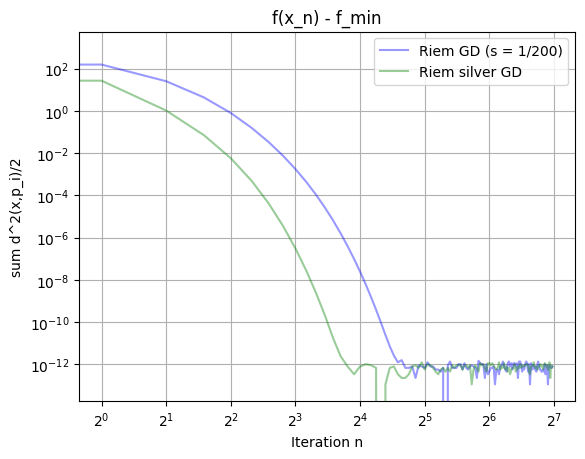

In [62]:
iterations = list(range(num_iter))  # Create the x-axis (iteration numbers)

# Define distinct colors for the lines
colors = ['blue', 'green']
labels = [f"Riem GD (s = 1/{L})", f"Riem silver GD"] # Labels for the legend

min_1 = np.min(gd_f_list)
min_2 = np.min(silver_f_list)
min_f = min(min_1, min_2)

plt.plot(iterations, gd_f_list - min_f, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, silver_f_list - min_f, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)

# plt.plot(iterations, gd_f_list, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, silver_f_list, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("sum d^2(x,p_i)/2")
plt.title(f"f(x_n) - f_min")
# plt.title("Target value over the iteration. (max_eig, min_eig) = (" + str(max_eig) + ", " + str(min_eig) + ")")
plt.xscale('log',base=2)
plt.yscale('log',base=10)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()